In [1]:
import pandas as pd
from collections import Counter
import spacy,re,json
from spacy.gold import GoldParse
from spacy.scorer import Scorer
from spacy import displacy  

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

import re
from pprint import pprint
import os
import warnings
warnings.filterwarnings('ignore')

from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import spacy
from spacy.util import minibatch, compounding

# ============================================================
## 基于 Spacy 的 NER 模型

In [2]:
PATH ='data/file_ner.json1'

annotated_data = []
lines=[]
with open(PATH, 'r',encoding = 'utf-8 sig') as f:
    lines = f.readlines()

for line in lines:
    data = json.loads(line)
    text = data['text']
    entities = []
    for label in data['labels']:
        entities.append(label)
    annotated_data.append((text, {"entities": data['labels']}))

In [3]:
training_data=  annotated_data[0:200]
test_data = annotated_data[200:220]

In [4]:
print(len(training_data), len(test_data))

200 20


In [5]:
training_data[0]

('"Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company\'s growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILLS  C (

In [6]:
def main(model=None, output_dir=None, n_iter=100):
    """Load the model, set up the pipeline and train the entity recognizer."""
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")

    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")

    # add labels
    for _, annotations in training_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # reset and initialize the weights randomly – but only if we're
        # training a new model
        if model is None:
            nlp.begin_training()
        for itn in range(n_iter):
            random.shuffle(training_data)
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(training_data, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                )
            print("Losses", losses)

    # test the trained model
    for text, _ in training_data:
        doc = nlp(text)
#         print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
#         print("Tokens", [(t.text, t.ent_type_, t.ent_iob) for t in doc])

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        for text, _ in training_data:
            doc = nlp2(text)
#             print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
#             print("Tokens", [(t.text, t.ent_type_, t.ent_iob) for t in doc])

# trained this model with 100 iterations in google colab using GPU runtime with loss: Losses {'ner': 465.24571515528373} 
main(output_dir='ner_model/') 

Created blank 'en' model
Losses {'ner': 16889.961593902088}
Losses {'ner': 2697.5885606127285}
Losses {'ner': 2744.089724993466}
Losses {'ner': 2825.1706454027}
Losses {'ner': 2487.06796729747}
Losses {'ner': 2293.7671482911956}
Losses {'ner': 2414.592029980423}
Losses {'ner': 2079.5062248590334}
Losses {'ner': 2140.9136387828835}
Losses {'ner': 2115.5998387992677}
Losses {'ner': 2140.5686549975217}
Losses {'ner': 1773.3107981665094}
Losses {'ner': 1749.3125200521604}
Losses {'ner': 1783.7525714743247}
Losses {'ner': 1749.503419123001}
Losses {'ner': 1792.6353750283993}
Losses {'ner': 1580.5342176150768}
Losses {'ner': 1474.0500409663866}
Losses {'ner': 1522.7503911667266}
Losses {'ner': 1523.5194834165798}
Losses {'ner': 1464.960874043458}
Losses {'ner': 1388.104255991477}
Losses {'ner': 1335.1260102155413}
Losses {'ner': 1285.2708202728818}
Losses {'ner': 1266.5353707549868}
Losses {'ner': 1189.9840920108427}
Losses {'ner': 1132.8286302185863}
Losses {'ner': 1375.8248131792627}
Losse

# ==========================================================
## 导入 NER 模型，识别 JD 中的所有技能类关键词

In [7]:
ner_model = spacy.load('ner_model/')

In [8]:
skill_set = {}
link_set = {}

In [9]:
ind = 0

for root,dirs,files in os.walk(r"E:\dataset\dataset"):
    for file in files:
        ind += 1
        
        try:
            #获取文件路径
            my_file = open( os.path.join(root,file),encoding = 'utf-8' )
            my_string = my_file.readlines()

            for string in my_string[1:]:
                doc = ner_model( string )

                temp_list = []
                for chunk in doc.ents:
                    temp_list.append( chunk.text )
                    
                temp_set = set( temp_list )
                
                for tem in list(temp_set):
                    if tem not in skill_set.keys():
                        print( tem )
                        
                    if skill_set.get( tem, 0 ) == 0:
                        skill_set[tem] = 1
                    else:
                        skill_set[tem] += 1
                        
                for t1 in list(temp_set):
                    for t2 in list(temp_set):
                        if t1.text != t2.text:
                            if link_set.get( t1+'|'+t2, 0 ) == 0:
                                link_set[t1+'|'+t2] = 1
                            else:
                                link_set[t1+'|'+t2] += 1
                            

            my_file.close()
        
            if ind % 100 == 0:
                print( '------------------------------------------------------------------------',ind )
                
#             if ind > 2000:
#                 break
                
        except:
            print('Error')

Machine Learning
Python
Error
BlackRock
Error
SQL
Error
artificial intelligence
Error
R
Error
C++
Map/Reduce
Linux
Java
C
Error
Error
SAS
MATLAB
Error
PHP
Data Pre
data modeling
Deep Learning
via SQL
software prototyping
Error
C ##
Advanced knowledge
Error
Javascript
C#
Error
Spark
Practical experience
Consumer experience
TensorFlow
Hadoop
Error
Data Analytics
Error
Adhoc analysis
Error
comparable NoSQL
Error
Monica
Error
·
Data Scientist
Error
PowerPoint
Error
Error
Program Management Services; Testing
Business Intelligence
Infrastructure Support
SAP HANA
AWS
Informatica
Cloud Enablement Services
Error
Error
Excel
Error
Redshift
S3
recruitment
Athena
Kinesis My
Error
Error
SPSS
Tensorflow
Error
feature engineering
Error
Error
Matlab
Error
Microsoft Office
Error
problem-solving
predictive
Error
Error
Oracle
non-parametric statistical
Error
MS Windows
Error
Visualization
Error
Data engineering
Error
Problem Solving
Error
Unit testing
Error
Error
predictive analytics
Error
Error
Error
No

Error
Error
Azure Analytics
Data Warehouse / ETL
Data Pipeline / Kafka
Ruby / DynamoDB
Azure / Cloud / AWS
Data Lake
Error
& Hadoop
selenium
Error
Error
Error
product
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
MSSQL Experience
XML
IC GovCLoud
Jira
Error
Error
Error
Unix
Error
Error
Error
Error
Error
Advanced experience
Error
Error
Error
Error
architecture
Error
Error
PMI
Error
Error
Github Experience
Microsoft office
Error
Error
a Ph
Error
Error
Error
extract patterns
Error
Error
Error
Call analytics
Error
Error
Error
Error
Error
Error
Error
Day Job
Error
Error
World leader
Error
Error
Error
Error
Error
Error
Mathematics
Error
------------------------------------------------------------------------ 900
Error
Political Methodology
Error
Error
Error
Error
Cloud Architecture
Azure ML
Error
Error
Error
Error
create modular
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
andor
Error
Error
Error
Error
Error
Error
Python andor
Error
E

Error
Error
Error
Error
Error
Error
Error
Error
Error
Network Management
Distribution Management System (DMS)
Error
Error
Error
Error
Error
Error
Ensembling
Data Analyts
Error
Error
Trianz
Error
Error
------------------------------------------------------------------------ 2000
Error
Error
data blending
Error
course performance
Error
Error
Error
Error
Error
SageMaker
Error
Data Warehouses
Error
+ SQL
Error
Error
R studio
Error
graph analytics
Data Labs
Error
Error
SSL
Error
Error
Error
Error
Error
Error
Work remote
Error
Error
Error
advanced expertise
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
DynamoDB
Google Cloud
Error
Error
Error
Error
Client Analytics
Digital Marketing
Inventory Planning
Error
Error
Error
Error
Error
Error
Error
Error
Hoboken
Error
H2O
Error
Error
Error
Spring
TX 

Error
Error
Error
Error
Error
Error
------------------------------------------------------------------------ 2100
Error
HR BI
Error
Error
Error
Error
Error
Error
Error
Error


Error
Error
Error
Error
Error
Error
demonstrate
Error
Error
Error
Houston
Error
Error
Error
Error
R  

Error
Error
Error
Error
Error
Error
Error
Data Warehousing
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Technical Services
Customer Service
Error
statistical analytics
Error
Error
Error
Error
-performance algorithms
Error
Error
Error
Error
Error
Error
Error
Error
Databricks
Error
Error
Error
Support patent
Error
Error
Error
Error
Error
Error
Error
Profit Sharing
Error
Error
Error
Error
Error
Error
Error
behavioral analytics
Error
Error
Error
Error
Global Analytics
Error
Error
Error
Error
Error
Sas
Error
Error
Power Query
and/or R
Error
Error
Error
Error
Error
Error
Error
Error
Error
consumer credit
Error
conversion
Error
#CB
Error
Error
Error
------------------------------------------------------------------------ 3400
data
Error
Error
Error
Error
Error
telephone
Error
Error
Silver Spring
Error
Error
statistical models
Error
Error
Error
Python Scripting
Error
Erro

Error
Error
Error
Error
Error
Error
Error
Error
Error
editing
Error
Error
Error
VBScript
Error
Error
Error
Error
linux
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
R & MATLAB
Jupyter Notebook Experience
Error
Error
Error
Analysis 8+SQL/R
Error
Computer Sciences
Neural Nets
Google
Adobe Analytics
Error
Error
Error
andMongoDB
Error
Error
Error
Error
Error
PMML
Error
Error
Error
Error
Error
Error
Error
Error
network protocols
Electrical Engineering
Error
Error
Error
Error
Error
Error
Python SQL
Error
Error
Error
operational analytics
Error
Error
Error
Error
Error
Error
Error
Error
Error
Keras
Error
Error
MS PowerPoint
Error
Advanced PowerPoint
SQL server)Visualization
Error
Learning
Error
Error
Error
portfolio
Error
Error
Informatica/ ETL
Error
Error
Office 365
Microsoft Advertising
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Au

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
packages
Error
Error
Error
Error
Error
Error
Error
Error
Data Robot
Error
Error
Error
Error
Error
Error
Error
Error
Error
------------------------------------------------------------------------ 6100
Error
Error
Error
Error
Error
Error
Error
web analytics
Error
Error
Error
Manufacturing
Error
Error
Error
Error
Error
Viacom
Pac-12 Networks
Hallmark
Error
Error
Error
Error
DISABILITY
Error
Error
Error
Error
Data Analysis experience
SQL & R
Error
Error
Error
Redis Experience
Error
R-Studio
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Architects gaining
Error
Error
C2S
microservice
data layers
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
episode analytics
power analysis
Error
Error
Error
Error
Error
Error
Error
software development
Error
Error
Error
National Offices
Error
Error
Error
Error
Error
Error
Cloud

Error
Error
Error
Error
Error
WAN
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Team building
Error
Error
robotics
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Actively shares resources
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
LI-JS1
Error
language understanding
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Html
Error
Numerical Analysis
Error
geospatial analytics
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Microsoft Access
Error
Error
Error
Error
Error
HQL
Error
Error
Error
Deep experience
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
At Acorns
Error
Error
technical docum

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Alberta
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Hierarchical Clustering
Multiple Regression
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
disciplineTypically
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
- SPARK
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
1.Industry Leader
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Image Analytics
Error
programming experience
Error
Error
Error
Error
Error
Error
Juice - The
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
SQLData Visualization
ex
Error
Error
Error
Error
Error
deep

In [10]:
skill_set = dict( Counter(skill_set).most_common(150) )
skill_set

{'Python': 950,
 'SQL': 695,
 'R': 502,
 'machine learning': 485,
 'Machine Learning': 334,
 'SAS': 334,
 'Data Scientist': 327,
 'Java': 279,
 'Spark': 264,
 'C++': 258,
 'Hadoop': 207,
 'C': 169,
 'AWS': 167,
 'Deep Learning': 152,
 'problem solving': 143,
 'deep learning': 128,
 'TensorFlow': 112,
 'S3': 112,
 'NoSQL': 110,
 'predictive analytics': 101,
 'Analytics': 100,
 'Artificial Intelligence': 99,
 'Linux': 94,
 'SPSS': 91,
 'Data Analytics': 87,
 'problem-solving': 86,
 'predictive modeling': 85,
 'Tensorflow': 83,
 'Oracle': 83,
 'Azure': 83,
 'EC2': 83,
 'comparable NoSQL': 79,
 'JavaScript': 74,
 'artificial intelligence': 68,
 'MATLAB': 66,
 'Redshift': 65,
 'Excel': 60,
 'Data Visualization': 60,
 'research': 60,
 'Microsoft Office': 59,
 'SQL Server': 57,
 'C#': 56,
 'Power BI': 55,
 'MS Office': 54,
 'PHP': 53,
 'ETL': 53,
 'PostgreSQL': 53,
 'Tableau': 52,
 'Predictive Analytics': 50,
 'MySQL': 49,
 'advanced analytics': 49,
 'statistical modeling': 47,
 'Unix': 47,
 

# ============================================================
## 基于句法分析抽取层级关系

In [20]:
nlp = spacy.load("en_core_web_sm")

In [21]:
def is_father( word, root ):
    if word == root:
        return True
    
    while word != word.head:
        word = word.head
        if word == root:
            return True
    
    return False

In [13]:
ind = 0

total_link_list = []
for root,dirs,files in os.walk(r"E:\dataset\dataset"):
    for file in files:
        ind += 1
        
        my_file = open( os.path.join(root,file),encoding = 'utf-8' )

        my_string = my_file.readlines()
        for string_list in my_string[1:]:
            string_list = string_list.replace('e.g.','like')
            string_list = string_list.replace('.)',')')
#             for string in [sentence for sentence in re.split(r'[？?！!。；;：:\n\r·]', string_list) if sentence]:
            for string in re.split(r'[？?！!。.；;：:\n\r·•*]', string_list):
#                 try:
                doc = nlp( string )

                my_chunks_list = []
                roor_chunks_dict = {}

                for chunk in doc.noun_chunks:
                    if chunk.text in skill_set.keys():
                        my_chunks_list.append( chunk.root )
                        roor_chunks_dict[ str(chunk.root)] = str(chunk)

                if len( my_chunks_list ) > 1:
#                     print( 'skill word:', my_chunks_list )
                    Total_List = []

                    for word in my_chunks_list:
                        temp_list = []
                        temp_list.append(word)

                        pre = word
                        while word != word.head:
                            pre = word
                            relation = word.dep_
                            word = word.head

                            if 'N' in word.tag_ and (relation != 'conj' and relation != 'appos'):
                                if word in my_chunks_list:
                                    temp_list.append( word )

                                    if len( [str( roor_chunks_dict[str(w)] ) for w in temp_list if 'xperience' not in str(w)] ) == 2:
                                            print(string)
                                            print('result1:')  
                                            print( '-->'.join([str( roor_chunks_dict[str(w)] ) for w in temp_list]) )
                                            total_link_list.append( [str( roor_chunks_dict[str(w)] ) for w in temp_list] )
                                            print()

                                else:
                                    tree_list = []
                                    for t in my_chunks_list:
                                        if t.dep_ == 'compound' and is_father( t, word ) == True and is_father( t, pre ) == False:
                                            tree_list.append( t )

                                    if len(tree_list) == 1:
                                        key1 = roor_chunks_dict[ str(temp_list[0]) ]
                                        key2 = roor_chunks_dict[ str(tree_list[0]) ]
                                        
                                        if 'xperience' not in key1 and 'xperience' not in key2:
                                            print(string)
                                            print('result2:')  
                                            
                                            print( '-->'.join( [ key1, key2 ] ) )
                                            total_link_list.append( [ key1, key2 ] )
                                            print()
                                break
                
        my_file.close()

        if ind % 500 == 0:
            print( '==================================================',ind )
            
        if ind > 500:
            break

Experience with sophisticated analyses (like, longitudinal modeling, machine learning, non-parametric statistical modeling) and data visualization (like, Tableau, Qlik, R Shiny, Microstrategy) is preferred
result1:
Tableau-->data visualization

 Experience with sophisticated analyses (like, longitudinal modeling, machine learning, non-parametric statistical modeling) and data visualization (like, Tableau, Qlik, R Shiny, Microstrategy) is preferred
result1:
Tableau-->data visualization

Advanced skill in use of Microsoft Office, including Outlook, Excel, Word, PowerPoint, and other computer applications including but not limited to skill in using shortcuts, macros, visual basic editing and advanced formulas)
result1:
Excel-->Microsoft Office

Advanced skill in use of Microsoft Office, including Outlook, Excel, Word, PowerPoint, and other computer applications including but not limited to skill in using shortcuts, macros, visual basic editing and advanced formulas)
result1:
Word-->Micros

In [14]:
ind = 0

total_link_list = []
for root,dirs,files in os.walk(r"E:\dataset\dataset"):
    for file in files:
        ind += 1
        
        my_file = open( os.path.join(root,file),encoding = 'utf-8' )

        my_string = my_file.readlines()
        for string_list in my_string[1:]:
            string_list = string_list.replace('e.g.','like')
            string_list = string_list.replace('.)',')')
#             for string in [sentence for sentence in re.split(r'[？?！!。；;：:\n\r·]', string_list) if sentence]:
            for string in re.split(r'[？?！!。.；;：:\n\r·•*]', string_list):
#                 try:
                doc = nlp( string )

                my_chunks_list = []
                roor_chunks_dict = {}

                for chunk in doc.noun_chunks:
                    if chunk.text in skill_set.keys():
                        my_chunks_list.append( chunk.root )
                        roor_chunks_dict[ str(chunk.root)] = str(chunk)

                if len( my_chunks_list ) > 1:
#                     print( 'skill word:', my_chunks_list )
                    Total_List = []

                    for word in my_chunks_list:
                        temp_list = []
                        temp_list.append(word)

                        pre = word
                        while word != word.head:
                            pre = word
                            relation = word.dep_
                            word = word.head

                            if 'N' in word.tag_ and (relation != 'conj' and relation != 'appos'):
                                if word in my_chunks_list:
                                    temp_list.append( word )

                                    if len( [str( roor_chunks_dict[str(w)] ) for w in temp_list if 'xperience' not in str(w)] ) == 2:
                                            print( '-->'.join([str( roor_chunks_dict[str(w)] ) for w in temp_list]) )
                                            total_link_list.append( [str( roor_chunks_dict[str(w)] ) for w in temp_list] )

                                else:
                                    tree_list = []
                                    for t in my_chunks_list:
                                        if t.dep_ == 'compound' and is_father( t, word ) == True and is_father( t, pre ) == False:
                                            tree_list.append( t )

                                    if len(tree_list) == 1:
                                        key1 = roor_chunks_dict[ str(temp_list[0]) ]
                                        key2 = roor_chunks_dict[ str(tree_list[0]) ]
                                        
                                        if 'xperience' not in key1 and 'xperience' not in key2:
                                            print( '-->'.join( [ key1, key2 ] ) )
                                            total_link_list.append( [ key1, key2 ] )
                                break
                                    
        my_file.close()

        if ind % 500 == 0:
            print( '==================================================',ind )

Tableau-->data visualization
Tableau-->data visualization
Excel-->Microsoft Office
Word-->Microsoft Office
PowerPoint-->Microsoft Office
Python-->Java
================================================== 500
predictive modeling-->advanced analytics
machine learning-->advanced analytics
optimization-->advanced analytics
hypothesis testing-->statistical analysis
Tableau-->data visualization
hypothesis testing-->statistical analysis
hypothesis testing-->statistical analysis
Python-->Java
predictive modeling-->advanced analytics
machine learning-->advanced analytics
optimization-->advanced analytics
predictive modeling-->advanced analytics
machine learning-->advanced analytics
optimization-->advanced analytics
predictive modeling-->advanced analytics
machine learning-->advanced analytics
optimization-->advanced analytics
MySQL-->databases
Python-->data visualization
R-->data visualization
Java-->data visualization
================================================== 1000
Word-->MS Office
Excel

Word-->Microsoft Office
Excel-->Microsoft Office
PowerPoint-->Microsoft Office
Python-->scripting
R-->scripting
SAS-->scripting
MATLAB-->scripting
R-->statistics
Python-->statistics
statistics-->machine learning
Economics-->Advanced degree
Statistics-->Advanced degree
Engineering-->Advanced degree
================================================== 7000
predictive modeling-->advanced analytics
optimization-->advanced analytics
predictive modeling-->advanced analytics
optimization-->advanced analytics
predictive modeling-->advanced analytics
optimization-->advanced analytics
predictive modeling-->advanced analytics
optimization-->advanced analytics
statistics-->machine learning
statistics-->machine learning
predictive modeling-->advanced analytics
optimization-->advanced analytics
predictive modeling-->advanced analytics
optimization-->advanced analytics
predictive modeling-->advanced analytics
optimization-->advanced analytics
predictive modeling-->advanced analytics
optimization-->adva

In [22]:
link_df = pd.DataFrame( total_link_list )
link_df = link_df.rename(columns = {0:'node1',1:'node2'})
link_df

,node1,node2
0,Tableau,data visualization
1,Tableau,data visualization
2,Excel,Microsoft Office
3,Word,Microsoft Office
4,PowerPoint,Microsoft Office
...,...,...
355,optimization,advanced analytics
356,predictive modeling,advanced analytics
357,machine learning,advanced analytics
358,optimization,advanced analytics


# 关系绘制

In [24]:
from unittest.mock import patch
from nose.tools import assert_equal, assert_in
from pyecharts import options as opts
from pyecharts.charts.basic_charts.graph import Graph

from pyecharts import options as opts
from pyecharts.charts import Graph

nodes = []
links = []

nodes_set = []

for ind, row in link_df.iterrows():
    
    if row['node1'] != row['node2']:
        
        if row['node1'] not in nodes_set:
            nodes_set.append( row['node1'] )
            nodes.append( {'name': row['node1'] , "symbolSize": 15 + skill_set[row['node1']] / 20 } )
            
        if row['node2'] not in nodes_set:
            nodes_set.append( row['node2'] )
            nodes.append( {'name': row['node2'] , "symbolSize": 15 + skill_set[row['node2']] / 20 } )
        
        links.append({"source": row['node2'], "target": row['node1']})

Graph().add(
    "", 
    nodes, 
    links, 
    repulsion=8000,
#     linestyle_opts=opts.LineStyleOpts(width=2, curve=0.1, opacity=0.9),
    linestyle_opts=opts.LineStyleOpts(width=0.5, curve=0.3, opacity=0.7),
    label_opts=opts.LabelOpts( ),
    categories=None,
    is_focusnode=True,
#     layout="none",
    is_roam=True
    
).set_global_opts(title_opts=opts.TitleOpts(title="Graph-基本示例")).render_notebook()

# 关系绘制

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Input data files check
# from subprocess import check_output

In [18]:
link_df

,node1,node2
0,Tableau,data visualization
1,Tableau,data visualization
2,Excel,Microsoft Office
3,Word,Microsoft Office
4,PowerPoint,Microsoft Office
...,...,...
355,optimization,advanced analytics
356,predictive modeling,advanced analytics
357,machine learning,advanced analytics
358,optimization,advanced analytics


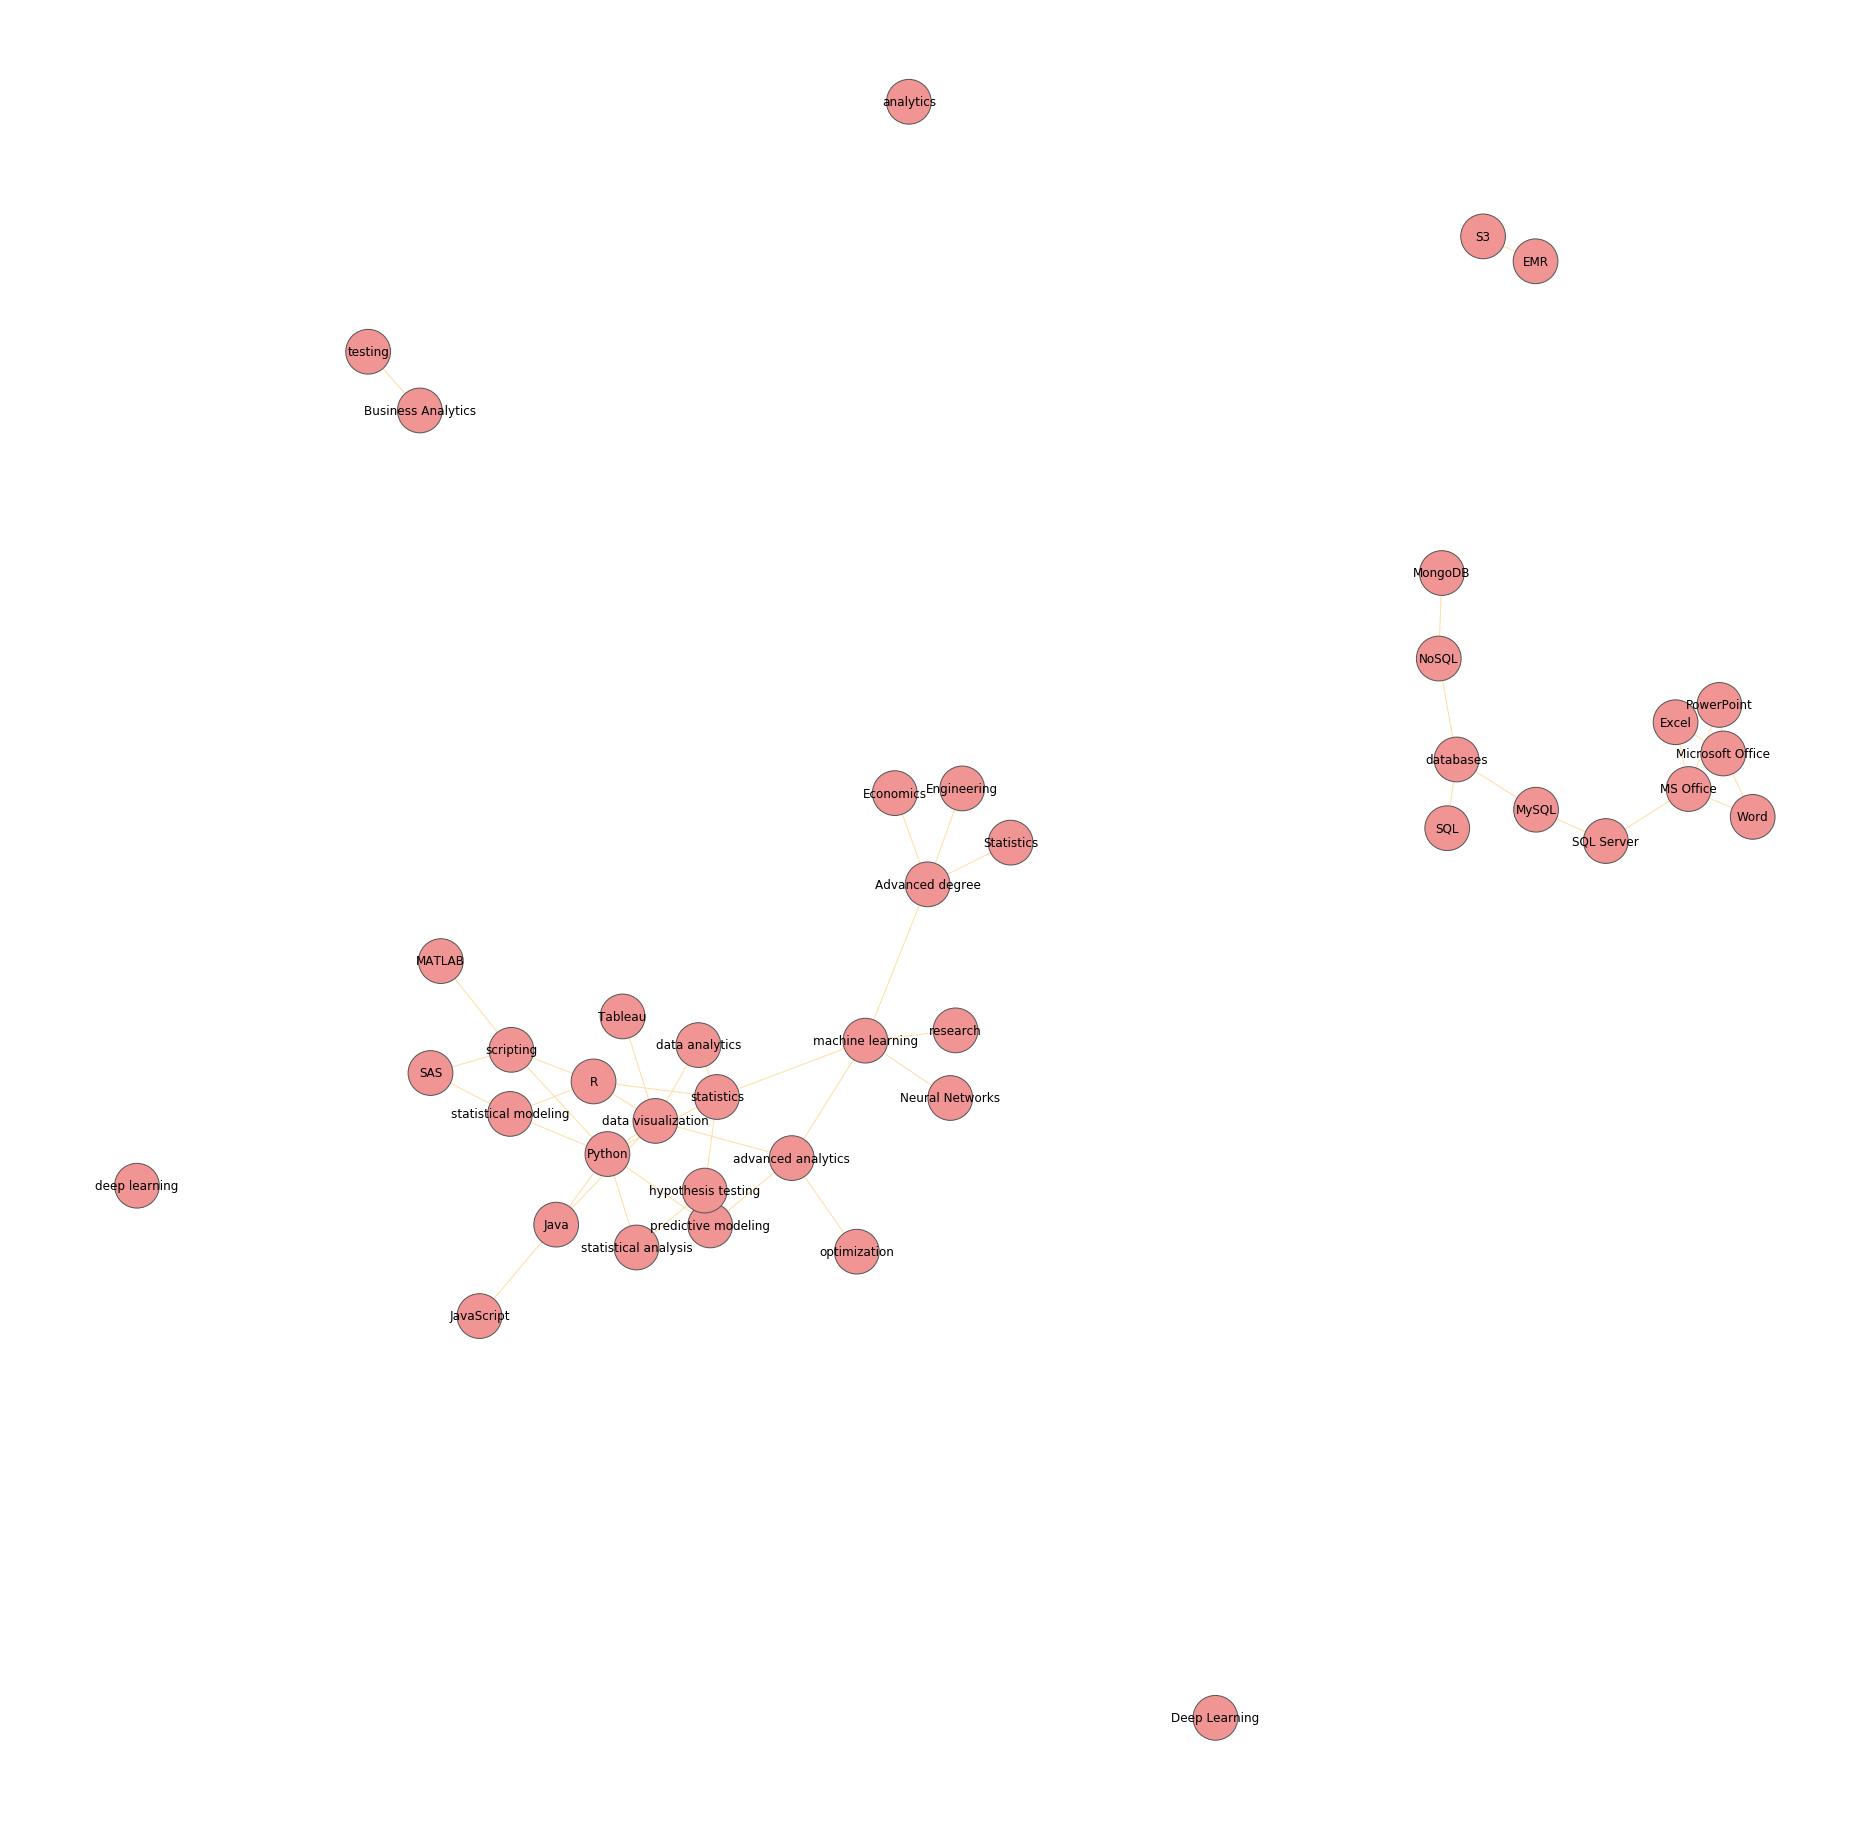

In [19]:
import warnings
warnings.filterwarnings('ignore')

G = nx.Graph(day="Stackoverflow")
# df_nodes = pd.read_csv('../input/stack_network_nodes.csv')
# df_edges = pd.read_csv('../input/stack_network_links.csv')

for index, row in link_df.iterrows():
    G.add_node(row['node1'], group=0, nodesize=200)
    G.add_node(row['node2'], group=0, nodesize=200)
    
for index, row in link_df.iterrows():
    G.add_weighted_edges_from([(row['node1'], row['node2'], 2)])
    
color_map = {1:'#f09494', 2:'#eebcbc', 3:'#72bbd0', 4:'#91f0a1', 5:'#629fff', 6:'#bcc2f2',  
             7:'#eebcbc', 8:'#f1f0c0', 9:'#d2ffe7', 10:'#caf3a6', 11:'#ffdf55', 12:'#ef77aa', 
             13:'#d6dcff', 14:'#d2f5f0'} 

plt.figure(figsize=(25,25))
options = {
    'edge_color': '#FFDEA2',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
}
colors = [color_map[1] for node in G]
sizes = [G.node[node]['nodesize']*10 for node in G]

"""
Using the spring layout : 
- k controls the distance between the nodes and varies between 0 and 1
- iterations is the number of times simulated annealing is run
default k=0.1 and iterations=50
"""
nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555") 
plt.show()